In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import logging
import datetime as dt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

import os
import sys
import tensorflow as tf
import time

In [2]:
cd /Users/kozlo/Downloads

C:\Users\kozlo\Downloads


In [3]:
%matplotlib inline
from pandas import read_csv
from matplotlib import pyplot
waw_ur = read_csv('Ursynow.csv', sep=";"
        )


print(waw_ur.head(5))
print(waw_ur.shape)
waw_ur=waw_ur.dropna()


  Zanieczyszczenie  UrsynowPM2_5  Wiatr
0  01.01.2021 1:00          23.3      2
1  01.01.2021 2:00          30.7      1
2  01.01.2021 3:00          30.7      2
3  01.01.2021 4:00          36.7      2
4  01.01.2021 5:00          38.3      1
(2136, 3)


In [4]:
cols = list(waw_ur)[1:3]

In [5]:
print('future selected:{}'.format(cols))

future selected:['UrsynowPM2_5', 'Wiatr']


In [6]:
data = waw_ur
waw = data.dropna()
waw = waw.drop(columns=['Zanieczyszczenie'
                       ])


<AxesSubplot:>

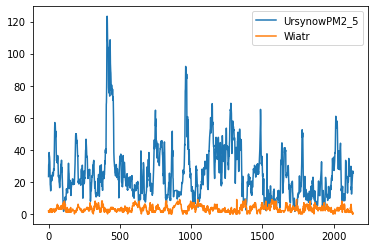

In [7]:
waw_ur = waw_ur.dropna()
waw.plot()

In [8]:
from datetime import datetime
import time
waw_ur['Zanieczyszczenie'] = pd.to_datetime(waw_ur['Zanieczyszczenie'], format = '%d.%m.%Y %H:%M')
waw_ur.index = waw_ur.Zanieczyszczenie

<ipython-input-9-bf2227df6156>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(waw_ur[['Wiatr']], freq=89


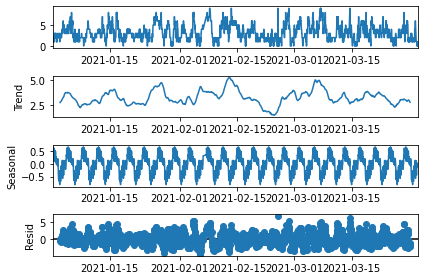

In [9]:
result = seasonal_decompose(waw_ur[['Wiatr']], freq=89
                           )

result.plot()
plt.show()

In [10]:
waw_ur.set_index('Zanieczyszczenie',inplace=True)
waw_ur.index=pd.to_datetime(waw_ur.index)
 
waw_ur.head()

,UrsynowPM2_5,Wiatr
Zanieczyszczenie,,
2021-01-01 01:00:00,23.3,2
2021-01-01 02:00:00,30.7,1
2021-01-01 03:00:00,30.7,2
2021-01-01 04:00:00,36.7,2
2021-01-01 05:00:00,38.3,1


In [11]:
waw_ur_multi = waw_ur[['UrsynowPM2_5','Wiatr']]
split = len(waw_ur) - int(0.2*len(waw_ur))
train_multi, test_multi = waw_ur_multi[0:split], waw_ur_multi[split:]

In [12]:
train_multi, test_multi

(                     UrsynowPM2_5  Wiatr
 Zanieczyszczenie                        
 2021-01-01 01:00:00          23.3      2
 2021-01-01 02:00:00          30.7      1
 2021-01-01 03:00:00          30.7      2
 2021-01-01 04:00:00          36.7      2
 2021-01-01 05:00:00          38.3      1
 ...                           ...    ...
 2021-03-13 05:00:00          17.3      3
 2021-03-13 06:00:00          20.0      2
 2021-03-13 07:00:00          20.4      4
 2021-03-13 08:00:00          19.6      3
 2021-03-13 09:00:00          13.9      3
 
 [1696 rows x 2 columns],
                      UrsynowPM2_5  Wiatr
 Zanieczyszczenie                        
 2021-03-13 10:00:00          12.9      4
 2021-03-13 11:00:00          10.5      4
 2021-03-13 12:00:00           8.8      5
 2021-03-13 13:00:00           7.8      4
 2021-03-13 14:00:00           5.2      3
 ...                           ...    ...
 2021-03-30 21:00:00          22.5      1
 2021-03-30 22:00:00          23.7      0
 2021-

In [17]:
waw_ur.isna().sum()

UrsynowPM2_5    0
Wiatr           0
dtype: int64

In [13]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller
def ad_test(waw_ur):
     wawtest = adfuller(waw_ur, autolag = 'AIC')
     print("1. ADF : ",wawtest[0])
     print("2. P-Value : ", wawtest[1])
     print("3. Num Of Lags : ", wawtest[2])
     print("4. Num Of Observations Used For ADF Regression:", wawtest[3])
     print("5. Critical Values :")
     for key, val in wawtest[4].items():
         print("\t",key, ": ", val)



In [14]:
ad_test(waw_ur['UrsynowPM2_5'])
# p> 0.05 ; Data is not stationary

1. ADF :  -5.72359147391706
2. P-Value :  6.85183650748806e-07
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression: 2095
5. Critical Values :
	 1% :  -3.433475217426538
	 5% :  -2.8629205871719057
	 10% :  -2.567504959814537


In [15]:
ad_test(waw_ur['Wiatr'])

1. ADF :  -9.444070110209966
2. P-Value :  4.807966414460983e-16
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 2116
5. Critical Values :
	 1% :  -3.433444163815172
	 5% :  -2.86290687612843
	 10% :  -2.567497659501288


In [16]:
waw_ur.describe()

,UrsynowPM2_5,Wiatr
count,2119.000000,2119.000000
mean,25.631760,3.201982
std,17.140939,1.811144
min,1.600000,0.000000
25%,13.400000,2.000000
50%,22.200000,3.000000
75%,33.000000,4.000000
max,123.300000,9.000000


In [17]:
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(train_multi['UrsynowPM2_5'], trace=True,
                          suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8799.035, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=14560.329, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9102.237, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12491.878, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16638.618, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8800.292, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8799.582, Time=0.42 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8801.050, Time=1.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8801.280, Time=1.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8803.001, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8800.948, Time=0.57 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8800.463, Time=0.66 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8802.965, Time=1.84 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8822.869, Time=0.17 sec

Best model:  ARIMA(2,0,2)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1696
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4393.518
Date:                Wed, 15 Dec 2021   AIC                           8799.035
Time:                        22:22:19   BIC                           8831.652
Sample:                             0   HQIC                          8811.111
                               - 1696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4420      0.213      2.071      0.038       0.024       0.860
ar.L1          1.6003      0.181      8.850      0.000       1.246       1.955
ar.L2         -0.6166      0.174     -3.547      0.000      -0.957      -0.276
ma.L1         -0.1878      0.182     -1.029      0.303      -0.545       0.170
ma.L2         -0.2163      0.090     -2.416      0.016      -0.392      -0.041
sigma2        10.3918      0.178     58.443      0.000      10.043      10.740
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3076.01
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.06
Prob(H) (two-sided):                  0.27   Kurtosis:                         9.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
from scipy.stats.stats import pearsonr
x = train_multi['UrsynowPM2_5'].values
y = train_multi['Wiatr'].values

corr , p = pearsonr(x,y)
print ('Corelation Coefficient =', corr,'\nP-Value =',p)

Corelation Coefficient = -0.3844937829424838 
P-Value = 7.152067947101771e-61


In [ ]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
# define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
# fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
# fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error


# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
# show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
# one failure during model validation suggests an unstable config
        try:
# never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
# define config lists
    p_params = [0, 1, 2]
    d_params = [1, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

if __name__ == '__main__':
# define dataset
  waw = read_csv('Ursynow.csv', sep=";", index_col=0)
    waw = waw.drop('Wiatr', axis=1)
    print(waw)
    data = waw.values
    print(data.shape)
# data split
  n_test = 4
# model configs
  cfg_list = sarima_configs()
# grid search
  scores = grid_search(data, cfg_list, n_test)
    print('done')
# list top 3 configs
  for cfg, error in scores[:3]:
    print(cfg, error)

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
mod = SARIMAX(train_multi['UrsynowPM2_5'], order=(2,0,2), seasonal_order=(1,1,1,4))
res = mod.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        UrsynowPM2_5   No. Observations:                 1696
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 4)   Log Likelihood               -4391.406
Date:                             Wed, 15 Dec 2021   AIC                           8796.811
Time:                                     22:22:23   BIC                           8834.847
Sample:                                          0   HQIC                          8810.896
                                            - 1696                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5874      0.197      8.061      0.000       1.201       1.973
ar.L2         -0.6039      

In [20]:
start = len(train_multi)
end = len(train_multi)+len(test_multi)-1
pred = res.predict(start=start, end=end,typ='levels')
pred
pred.index=waw_ur.index[start:end+1]
#pred.index

<AxesSubplot:xlabel='Zanieczyszczenie'>

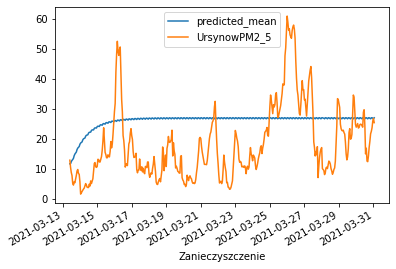

In [21]:
pred.plot(legend=True)
test_multi['UrsynowPM2_5'].plot(legend=True)

In [22]:
test_multi['UrsynowPM2_5'].mean()


18.364775413711588

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test_multi['UrsynowPM2_5']))
rmse

14.153807022700752

In [24]:
model2=SARIMAX(waw_ur['UrsynowPM2_5'], order=(1,1,0))
model2=model2.fit()
waw_ur.tail()

,UrsynowPM2_5,Wiatr
Zanieczyszczenie,,
2021-03-30 21:00:00,22.5,1
2021-03-30 22:00:00,23.7,0
2021-03-30 23:00:00,25.9,1
2021-03-31 00:00:00,26.8,0
2021-03-31 01:00:00,25.4,0


In [25]:
index_future_dates=pd.date_range(start='2021-03-31 01:00:00',end='2021-04-30 23:00:00')
#print(index_future_dates) 
pred=model2.predict(start=len(waw_ur),end=len(waw_ur) + 30, typ='levels').rename('SARIMAX Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2021-03-31 01:00:00    24.871164
2021-04-01 01:00:00    24.671402
2021-04-02 01:00:00    24.595944
2021-04-03 01:00:00    24.567440
2021-04-04 01:00:00    24.556673
2021-04-05 01:00:00    24.552606
2021-04-06 01:00:00    24.551070
2021-04-07 01:00:00    24.550490
2021-04-08 01:00:00    24.550271
2021-04-09 01:00:00    24.550188
2021-04-10 01:00:00    24.550156
2021-04-11 01:00:00    24.550145
2021-04-12 01:00:00    24.550140
2021-04-13 01:00:00    24.550139
2021-04-14 01:00:00    24.550138
2021-04-15 01:00:00    24.550138
2021-04-16 01:00:00    24.550138
2021-04-17 01:00:00    24.550138
2021-04-18 01:00:00    24.550137
2021-04-19 01:00:00    24.550137
2021-04-20 01:00:00    24.550137
2021-04-21 01:00:00    24.550137
2021-04-22 01:00:00    24.550137
2021-04-23 01:00:00    24.550137
2021-04-24 01:00:00    24.550137
2021-04-25 01:00:00    24.550137
2021-04-26 01:00:00    24.550137
2021-04-27 01:00:00    24.550137
2021-04-28 01:00:00    24.550137
2021-04-29 01:00:00    24.550137
2021-04-30

<AxesSubplot:>

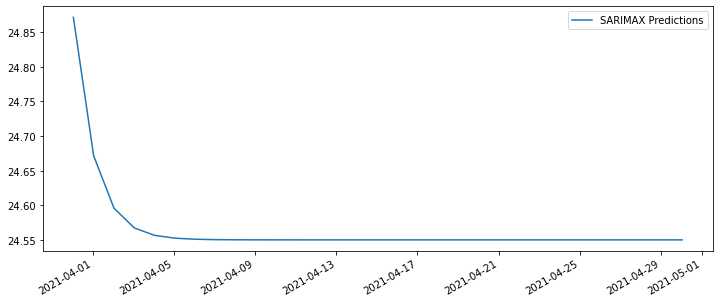

In [26]:
pred.plot(figsize=(12,5),legend=True)

In [27]:
dataset.plot(figsize=(10, 6))
dataset_mean.plot(figsize=(10, 6))

NameError: name 'dataset' is not defined